In [1]:
%matplotlib inline
import sys
import math

from logging import info
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import xgboost as xgb
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.manifold import TSNE

import features

from dataset import read_datasets, read_leap_motion_data
from features import extract_features, extract_lp_features
from train import precision_for, train_clf, feature_precisions
from utils import print_log, set_cache, get_cache
from draw import plot

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Dataset Load
ORIGIN_DATA = True
load_cache = True
if ORIGIN_DATA:
    persons = read_datasets(load_cache=load_cache)
else:
    persons = read_leap_motion_data('LP_data/dataset', load_cache=load_cache)

Using cache for persons
Time for >> read_datasets <<: 3.31 s


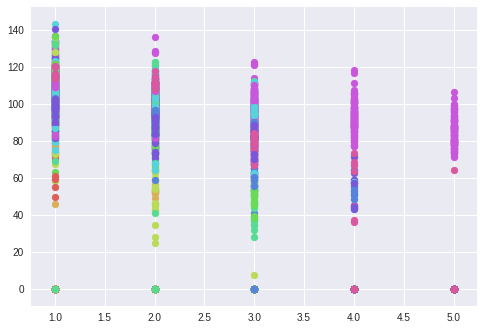

In [19]:
# persons['P1']['G1'][1]['lm']['FingertipsDistances']
person_keys = ['P%d' % i for i in range(1, 15)]
gesture_keys = ['G%d' % i for i in range(1, 11)]
xticks = [1, 2, 3, 4, 5]
colors = sns.color_palette("hls", 10)
dists = []
y = []

for p in person_keys:
    for idx, g in enumerate(gesture_keys):
        for r in range(1, 11):
            dist = sorted(persons[p][g][r]['lm']['FingertipsDistances'], reverse=True)
            y.append(idx)
            dists.append(dist)
            plt.scatter(xticks, dist, c=colors[idx])
    
y = np.array(y)
x = np.array(dists)
plt.show()

In [20]:
print(x.shape)
norm_x = x / np.max(x)
x[-50:, :]

(1400, 5)


array([[ 105.085 ,  103.014 ,   95.6877,    0.    ,    0.    ],
       [ 104.272 ,  103.79  ,   97.4225,    0.    ,    0.    ],
       [ 104.52  ,  103.233 ,   93.6725,    0.    ,    0.    ],
       [ 107.476 ,  106.717 ,   93.8488,    0.    ,    0.    ],
       [ 111.56  ,  109.222 ,   97.6114,    0.    ,    0.    ],
       [ 106.13  ,   97.5221,   94.1874,    0.    ,    0.    ],
       [  99.8972,   98.7112,   94.7108,    0.    ,    0.    ],
       [  87.0614,   85.3708,   79.0514,    0.    ,    0.    ],
       [  90.9415,   86.0213,   80.7   ,    0.    ,    0.    ],
       [ 107.143 ,  103.265 ,   98.2443,    0.    ,    0.    ],
       [  96.6466,   96.646 ,   60.4377,    0.    ,    0.    ],
       [  99.868 ,   91.9766,   90.0567,    0.    ,    0.    ],
       [  98.2967,   94.7899,   58.7462,    0.    ,    0.    ],
       [ 102.93  ,   96.6461,    0.    ,    0.    ,    0.    ],
       [  97.9375,   91.5816,   55.6988,    0.    ,    0.    ],
       [  91.9127,   83.8617,    0.    ,

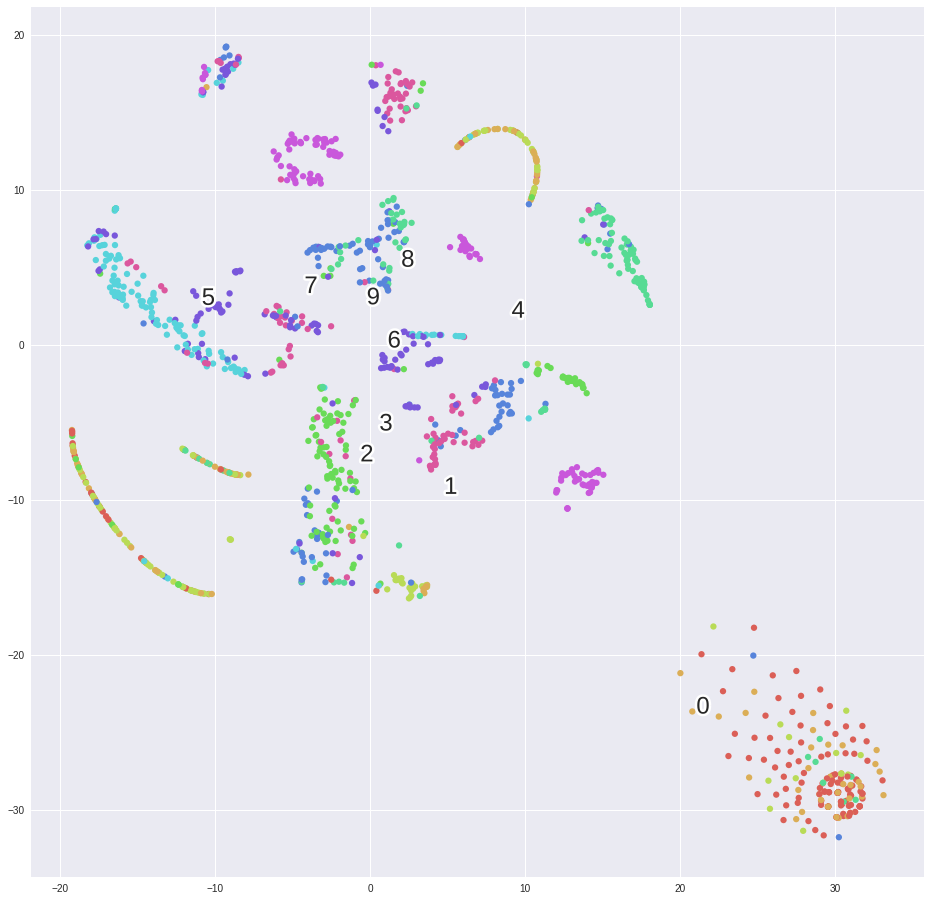

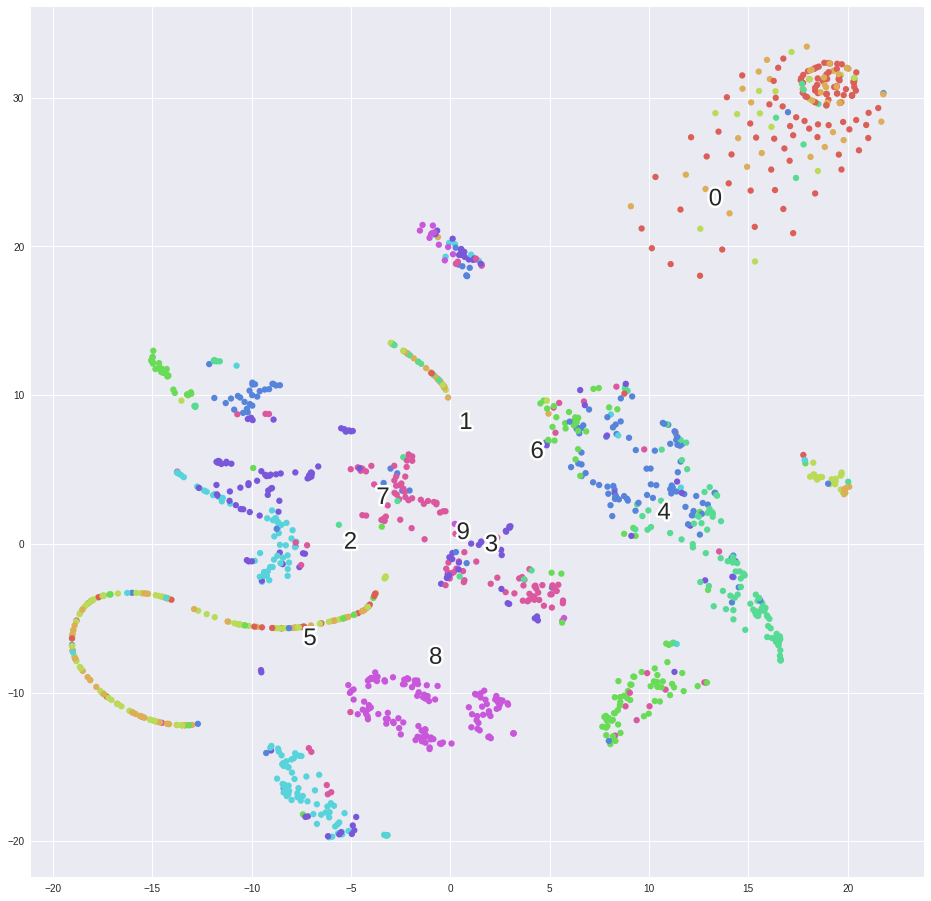

In [21]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(16, 16))
    if x.shape[1] == 2:
        ax = plt.subplot(aspect='equal')
        sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                        c=palette[colors.astype(np.int)])
    elif x.shape[1] == 3:
        ax = Axes3D(f)
        sc = ax.scatter(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                        c=palette[colors.astype(np.int)]) 

    #plt.xlim(-10, 10)
    #plt.ylim(-10, 10)
    ax.axis('on')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        pos = np.mean(x[colors == i, :], axis=0)
        txt = ax.text(*pos, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

tsne_x = TSNE(2).fit_transform(norm_x)
f, ax, sc, txts = scatter(tsne_x, y)

tsne_x = TSNE(2).fit_transform(x)
f, ax, sc, txts = scatter(tsne_x, y)

In [15]:
def find_best_params(x, y):
    X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2)

    tuned_parameters = {'estimator__gamma': [10**-i for i in range(5)], 'estimator__C': [10**i for i in range(4)]}

    scores = ['accuracy']

    model = OneVsOneClassifier(SVC())

    for score in scores:
        print("# Tuning hyper-parameters for %s\n" % score)

        clf = GridSearchCV(model, tuned_parameters, cv=10,
                           scoring=score)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:\n")
        print(clf.best_params_, '\n')
        print("Grid scores on development set:\n")
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:\n")
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.\n")
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred), '\n')
    params = {k.replace('estimator__', ''):v for k, v in clf.best_params_.items()}
    print('Best parameters ready to train:', params)
    return params

In [22]:
best_params = find_best_params(x, y)
norm_best_params = find_best_params(norm_x, y)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'estimator__gamma': 0.001, 'estimator__C': 10} 

Grid scores on development set:

0.461 (+/-0.068) for {'estimator__gamma': 1, 'estimator__C': 1}
0.681 (+/-0.116) for {'estimator__gamma': 0.1, 'estimator__C': 1}
0.725 (+/-0.069) for {'estimator__gamma': 0.01, 'estimator__C': 1}
0.715 (+/-0.089) for {'estimator__gamma': 0.001, 'estimator__C': 1}
0.646 (+/-0.060) for {'estimator__gamma': 0.0001, 'estimator__C': 1}
0.471 (+/-0.065) for {'estimator__gamma': 1, 'estimator__C': 10}
0.646 (+/-0.112) for {'estimator__gamma': 0.1, 'estimator__C': 10}
0.724 (+/-0.060) for {'estimator__gamma': 0.01, 'estimator__C': 10}
0.734 (+/-0.061) for {'estimator__gamma': 0.001, 'estimator__C': 10}
0.707 (+/-0.073) for {'estimator__gamma': 0.0001, 'estimator__C': 10}
0.475 (+/-0.072) for {'estimator__gamma': 1, 'estimator__C': 100}
0.617 (+/-0.089) for {'estimator__gamma': 0.1, 'estimator__C': 100}
0.701 (+/-0.092) for {'